# Instructions

We were given two datasets originating from online hotel reservations: 
1. Dataset '2024_DS2_HW1_data_train.csv' contains the reservation attributes together with the target, which is binary variable BOOKING_STATUS, and is intended for model training,
2. Dataset '2024_DS2_HW1_data_test.csv' contains same attributes as dataset above with expection of the target and is to be used as underyling data for prediction and model performance evaluation

Data consists of 32 647 +___ (train + test) with follwoing attributes:
- Booking_ID: unique identifier of each booking- 
no_of_adults: Number of adults- 
no_of_children: Number of Childre- n
no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hot- el
no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the ho- tel
type_of_meal_plan: Type of meal plan booked by the customer:
required_car_parking_space: Does the customer require a car parking space? (0 - No, 1--  Yes)
room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN H- otels.
lead_time: Number of days between the date of booking and the arriv- al date
arrival_year: Year of arri- val date
arrival_month: Month of arr- ival date
arrival_date: Date of-  the month
market_segment_type: Market segment d- esignation.
repeated_guest: Is the customer a repeated guest? (0 --  No, 1- Yes)
no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the cu- rrent booking
no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the c- urrent booking
avg_price_per_room: Average price per day of the reservation; prices of the rooms are dyna- mic. (in euros)
no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view fro- m the room, etc)
booking_status: Flag indicating if the booking wa

Our task is to predict of the customer is going to cancel the reservation or not using xgboost.XGBClassifier method.

The evaluation metric was AUC and prediction on test dataset was evaluated in Kaggle under team 'Wiedźmini': 
https://www.kaggle.com/competitions/data-science-2-2024-hw1/overviews canceled or not.

# Import packages

In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from pathlib import Path

In [79]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200


# Load Data


## Loading training data
Following script will load data from designed dataset.


In [80]:
# Load data - set index column, decimal point, separator
data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-22 22:23:22


In [81]:
data.head()
#´Quick check, if the dataset was loaded properly

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [82]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


## Loading data for prediction

In [83]:
# Load test data - set index column, decimal point, separator
test_data_file = Path("../Assigment1/Data1/2024_DS2_HW1_data_test.csv")
test_data = pd.read_csv(test_data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print data info
print(f'Number of rows:   {test_data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {test_data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {test_data.shape[1]:,}'.replace(',', ' '))

Number of rows:   3 593
Number of unique indexes:   3 593
Number of columns:   17


# Data exploration

In following snippits of code we employed some basic exploration tools to better understand the nature of the variables.

# Metadata Definitions

In following section we prepare our data for the xgboost. Firstly we explored spread of the target and also how many missing value are there. Next we categorized potential predictors into two groups depending on their type. (Categorical and Numerical)

In [84]:
# check values in column booking_status
data.booking_status.value_counts(dropna=False)
#352 NA values

booking_status
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [86]:
#We prepated labeling for eassier handeling 

#name of the target column
col_target = "booking_status"
#name of the month column
col_month = "arrival_month"

In [87]:
# define list of predictors
cols_pred = list(data.columns[0:-1])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
required_car_parking_space              float64
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
dtype: object

Categorical predictors:
-----------------------
type_of_meal_plan      object
room_type_reserved     object
market_segment_type    object
dtype: object


Since xgboost is unable to handle the predictors, one of out tasks will be to encode them correctly (namely type_of_meal_plan, room_type_reserved, market_segment_type)

# Data exploration


In [88]:
#Basic data desciption
description = data.describe(include='all').transpose()
pd.options.display.max_rows = 1000
display(description)
pd.options.display.max_rows = 200

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
no_of_adults,28231.0,NaN,NaN,NaN,1.845312,0.51686,0.0,2.0,2.0,2.0,4.0
no_of_children,5043.0,NaN,NaN,NaN,0.10351,0.407673,0.0,0.0,0.0,0.0,9.0
no_of_weekend_nights,7729.0,NaN,NaN,NaN,0.807737,0.873931,0.0,0.0,1.0,2.0,7.0
no_of_week_nights,24287.0,NaN,NaN,NaN,2.204966,1.411324,0.0,1.0,2.0,3.0,17.0
type_of_meal_plan,16544,4,Meal Plan 1,12767,NaN,NaN,NaN,NaN,NaN,NaN,NaN
required_car_parking_space,17863.0,NaN,NaN,NaN,0.033645,0.180319,0.0,0.0,0.0,0.0,1.0
room_type_reserved,11360,7,Room_Type 1,8812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lead_time,6935.0,NaN,NaN,NaN,86.213266,85.926525,0.0,18.0,59.0,127.0,443.0
arrival_year,29654.0,NaN,NaN,NaN,2017.820092,0.384118,2017.0,2018.0,2018.0,2018.0,2018.0
arrival_month,31740.0,NaN,NaN,NaN,7.419817,3.062828,1.0,5.0,8.0,10.0,12.0


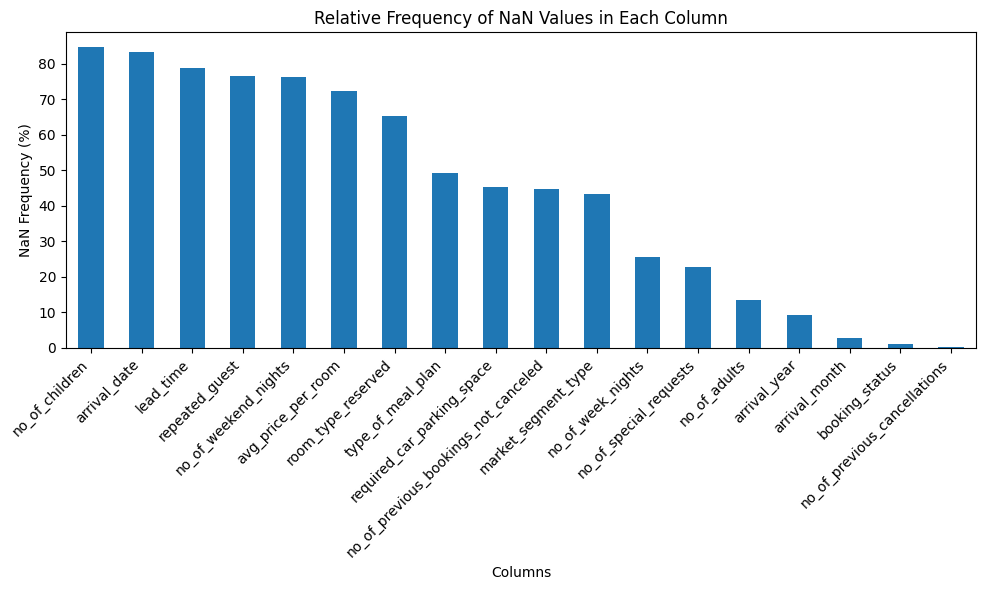

In [89]:
#Plots relative NA values present in each predictorb
def plot_nan_counts(data):
    # Count NaN values for each column
    nan_counts = data.isna().sum()
    
    # Calculate relative frequency of NaN values
    total_rows = len(data)
    relative_nan_counts = nan_counts / total_rows * 100  # Convert to percentage
    
    # Sort the results
    relative_nan_counts_sorted = relative_nan_counts.sort_values(ascending=False)
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    relative_nan_counts_sorted.plot(kind='bar')
    plt.title('Relative Frequency of NaN Values in Each Column')
    plt.xlabel('Columns')
    plt.ylabel('NaN Frequency (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'data' is your DataFrame
# Replace 'data' with the name of your DataFrame if it's different
plot_nan_counts(data)

We can spot that some of the predictors has high amount of missing values providing possible insight on the power and significance in modelling.

# Data Split

In this part we will deal with splitting the dataset into three subset: train and valid and also visualize them (test is not needed #??? and hence we save BLABLAB). Notably, we used stratification to gain the most evenly spread sample across the individual groups. Furthemore, for xgboost prediction to work properly, we nedeed to dealt with any missing values in the target. From previous section we learned there are 352 missing values, which is about 0.1 % of the sample. Working with fact, we simply ignored them.

In [91]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.6])
    plt.ylabel('default rate')
    plt.xlabel('month')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

In [92]:
#??? Why did we do it?

data[col_month].fillna(13, inplace=True)

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_7064\2060574042.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col_month].fillna(13, inplace=True)


In [93]:
data['sample'] = 'default'
target_mask = (data[col_target] >= 0) & (data[col_target] <= 1) #Restricting to reasonable values

data_train, data_valid = train_test_split(data[target_mask], test_size=0.05, random_state = 12, stratify = (data[target_mask][[col_target]])) #train and valid split using stratification wrt to #???
data.loc[data_train.index, 'sample'] = 'train'
data.loc[data_valid.index, 'sample'] = 'valid'
#data.loc[data_test.index, 'sample'] = 'test'

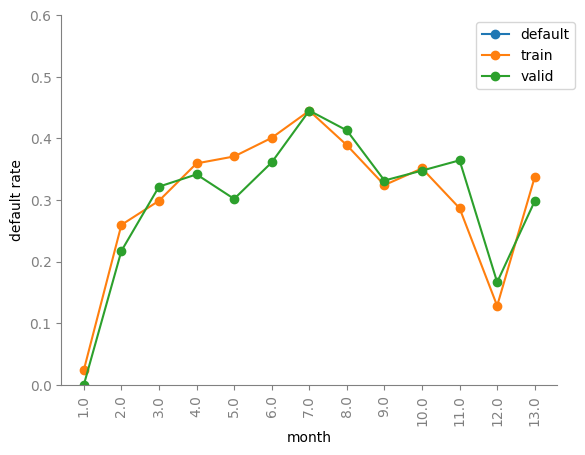

In [94]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')
#Visualization

Once again in order to využít missing values as additional info we created 13th month.

In [95]:
data[col_month].replace(13, np.nan, inplace=True)
data_train[col_month].replace(13, np.nan, inplace=True)
data_valid[col_month].replace(13, np.nan, inplace=True)
data_test[col_month].replace(13, np.nan, inplace=True)

C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_7064\400422843.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col_month].replace(13, np.nan, inplace=True)
C:\Users\Uzivatel\AppData\Local\Temp\ipykernel_7064\400422843.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

NameError: name 'data_test' is not defined

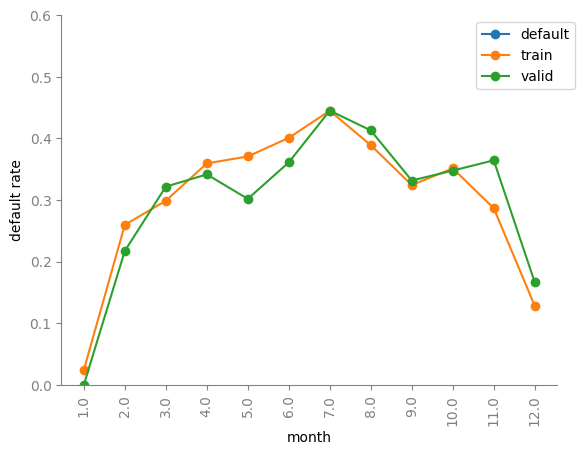

In [96]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')
#data with 13th month

## Define Sample Masks

In [97]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
#test_mask = (data['sample'] == 'test') 

## Additional visualization

In order to gain more information, we plotted the data in several ways. What's more we were able to access the quality of the given data and look for any potential outliers as well as possible transformation. Overall all predictors seemed to be in 'good condiction', no nonsense values or incorrect data type were present.

In [98]:
#Almost self explanatory: Plots the mean of booking status wrt to each value present in the predictor
def plot_smoothed_means(data, col_target, col_month):
    # Group the data by col_month and calculate the mean of col_target for each group
    grouped_data = data.groupby(col_month)[col_target].mean().reset_index()
    
    # Smooth the data using rolling mean to create a smoother plot
    smoothed_means = grouped_data[col_target].rolling(window=3, min_periods=1).mean()
    
    # Plot the smoothed means
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=grouped_data[col_month], y=smoothed_means)
    plt.xlabel(col_month)
    plt.ylabel("Mean " + col_target)
    plt.title("Smoothed Mean " + col_target + " by " + col_month)
    plt.grid(True)
    plt.show()


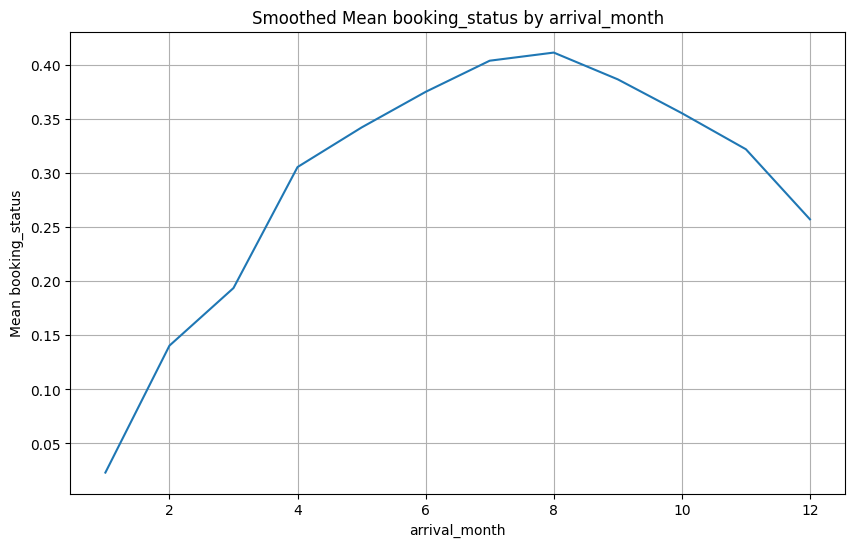

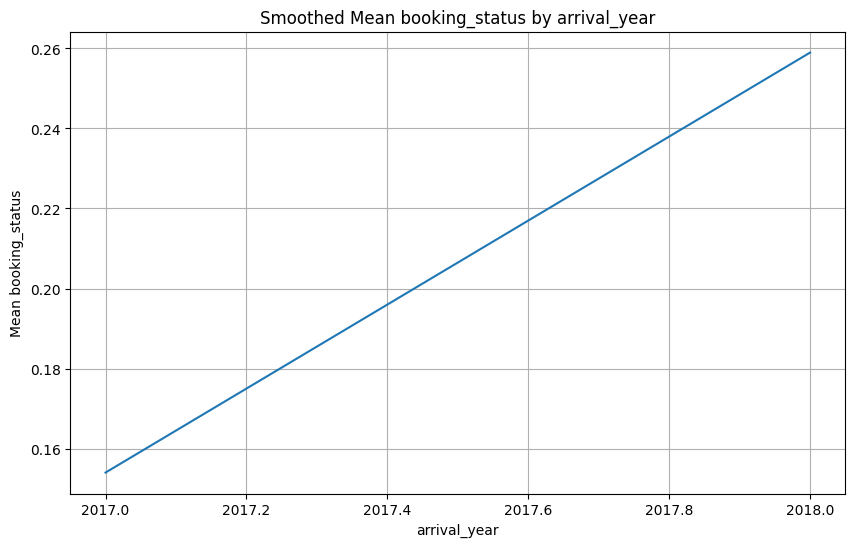

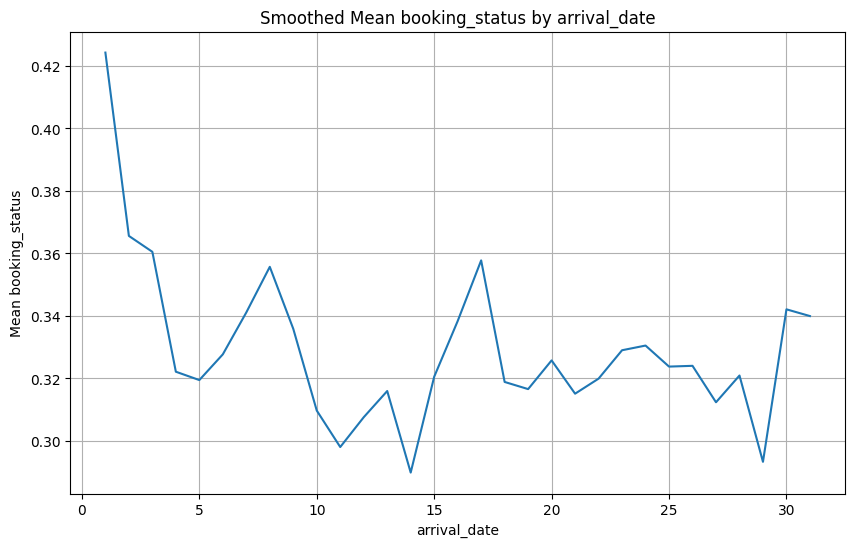

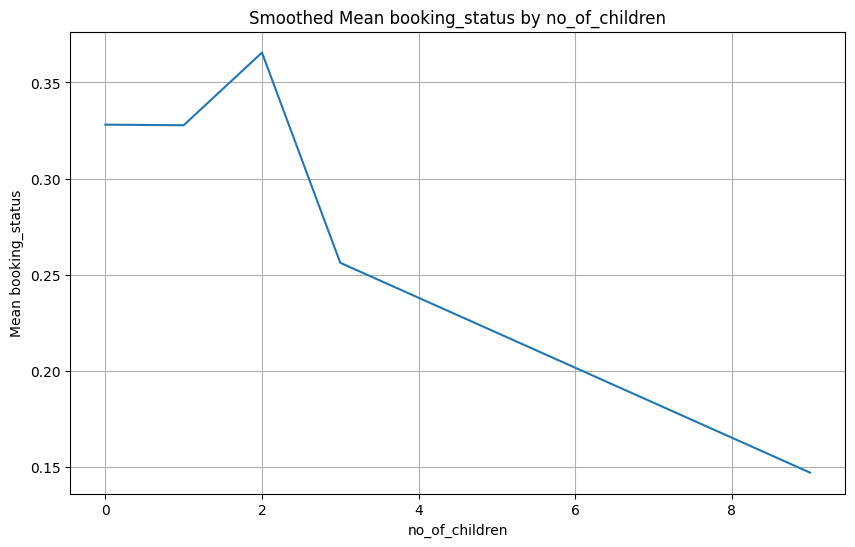

In [99]:
plot_smoothed_means(data, col_target, col_month)
plot_smoothed_means(data, col_target, 'arrival_year')
plot_smoothed_means(data, col_target, 'arrival_date')
plot_smoothed_means(data, col_target, 'no_of_children')


In [100]:
#Plots all predictors, namely histograms and the percentage of NA values in each predictor wrt to the sample
def plot_columns(columns, df):
    for col in columns:
        print('-' * 50)
        print('{}'.format(col.upper()))
        print('-' * 50)
        print('')
        k = int(df[col].nunique())
        
        
        if k < 2:
            print(f'{col} - only constant with value {df[col].unique()}')
        elif (k < 15) or (df[col].dtype == 'O'):
            info = '{:.2f}% is missing'.format(np.mean(df[col].isna()) * 100)
            print(info)
            
            ax = (df[col].value_counts(dropna=False).iloc[0:15] / df[col].shape[0]).plot.bar()
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            for p in ax.patches:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy() 
                _ = ax.annotate('{:.2f}%'.format(height * 100), (x + width/2, y + height + 0.02), ha='center')
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)


            plt.show()
            
        else:
            info = '{:.2f}% above 0'.format(np.mean(np.where(df[col] > 0, 1, 0)) * 100)
            print(info)

            info = '{:.2f}% is missing'.format(np.mean(df[col].isna()) * 100)
            print(info)
            
            ax = df[col].hist(log=True)
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            plt.show()

            ax = df[col].hist(log=False)
            _ = ax.set_title('\n' + col.replace('_', ' ').upper() + '\n')
            plt.show()

                

    print('\n')

--------------------------------------------------
NO_OF_ADULTS
--------------------------------------------------

13.53% is missing


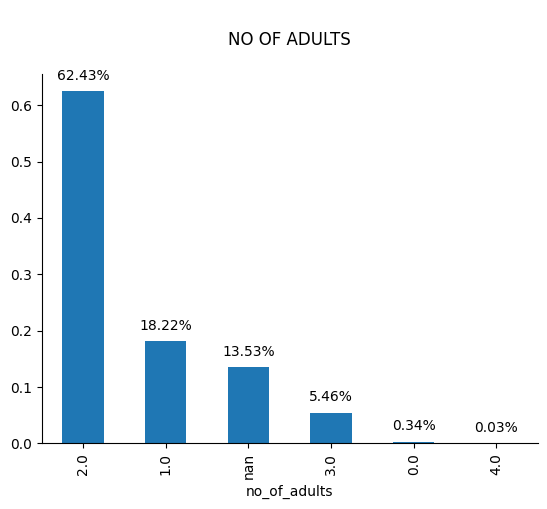

--------------------------------------------------
NO_OF_CHILDREN
--------------------------------------------------

84.55% is missing


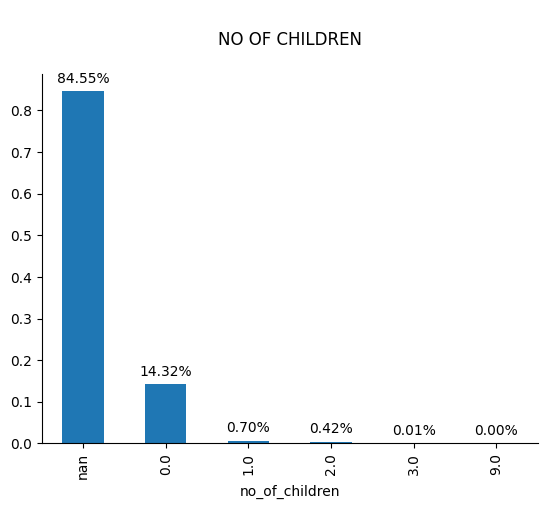

--------------------------------------------------
NO_OF_WEEKEND_NIGHTS
--------------------------------------------------

76.33% is missing


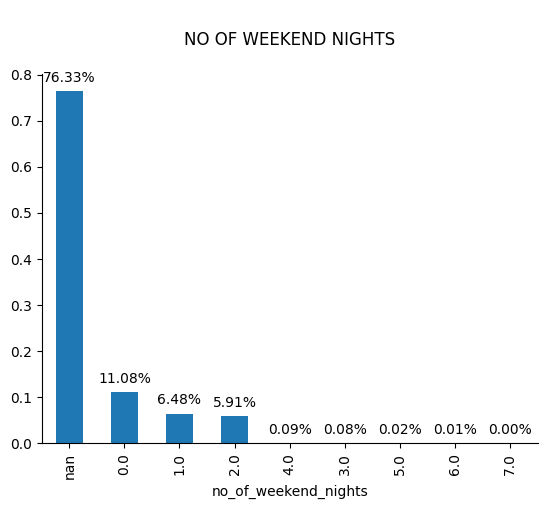

--------------------------------------------------
NO_OF_WEEK_NIGHTS
--------------------------------------------------

69.55% above 0
25.61% is missing


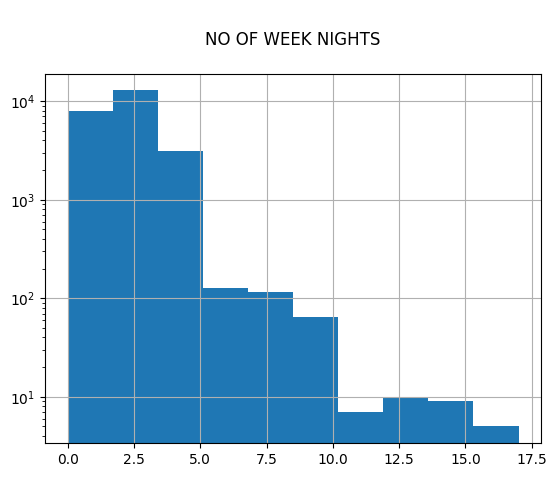

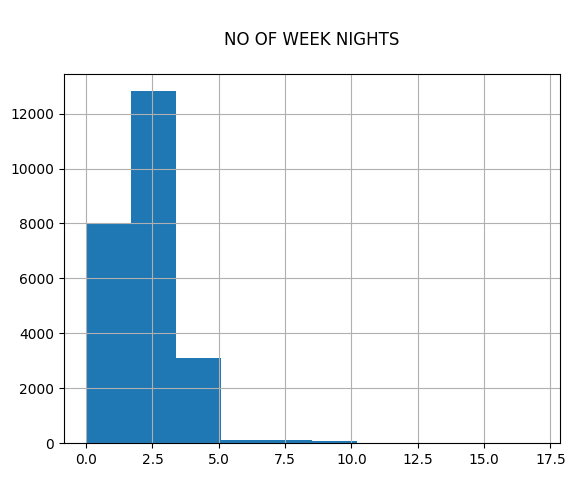

--------------------------------------------------
TYPE_OF_MEAL_PLAN
--------------------------------------------------

49.32% is missing


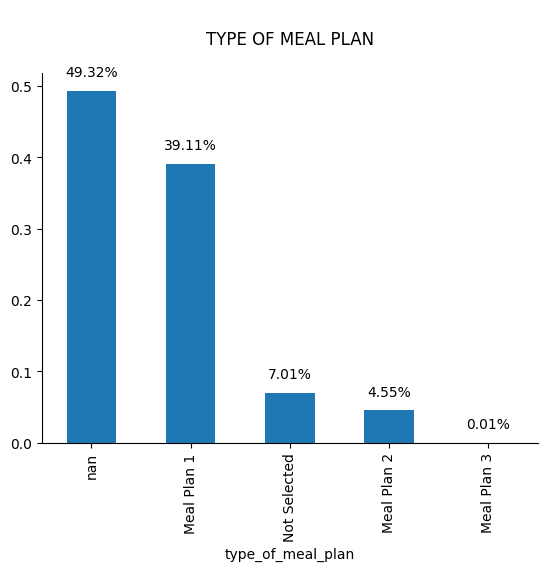

--------------------------------------------------
REQUIRED_CAR_PARKING_SPACE
--------------------------------------------------

45.28% is missing


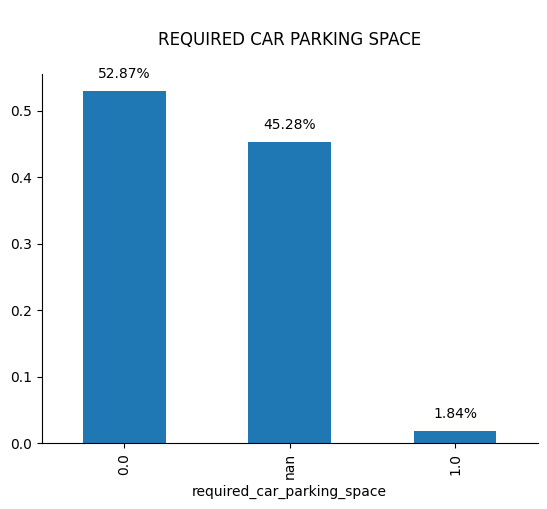

--------------------------------------------------
ROOM_TYPE_RESERVED
--------------------------------------------------

65.20% is missing


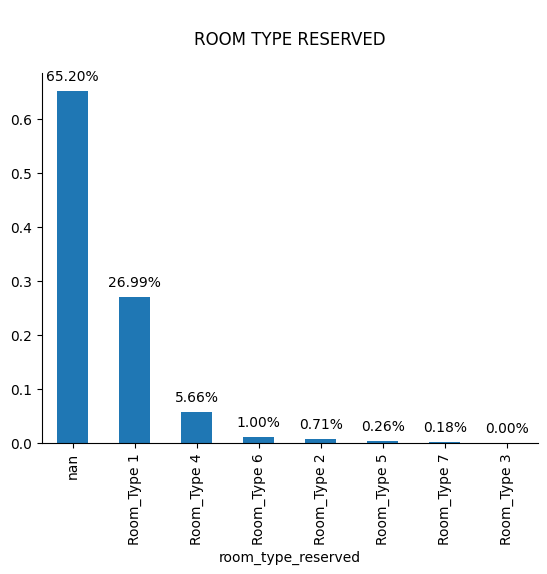

--------------------------------------------------
LEAD_TIME
--------------------------------------------------

20.52% above 0
78.76% is missing


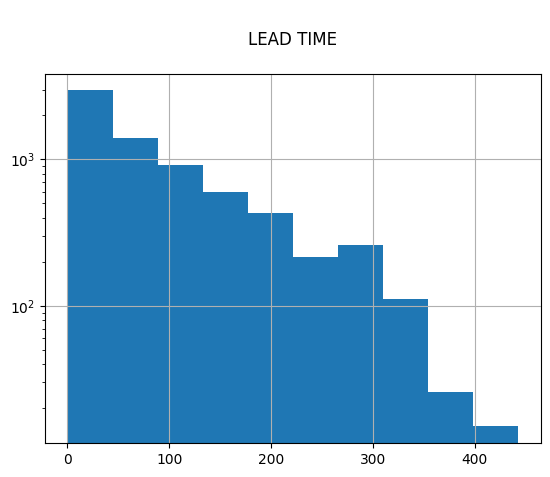

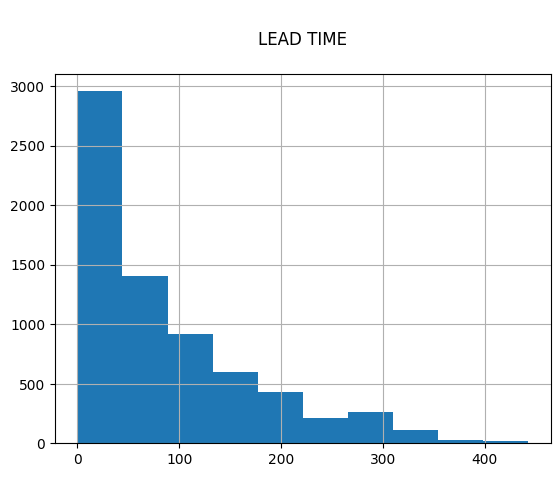

--------------------------------------------------
ARRIVAL_YEAR
--------------------------------------------------

9.17% is missing


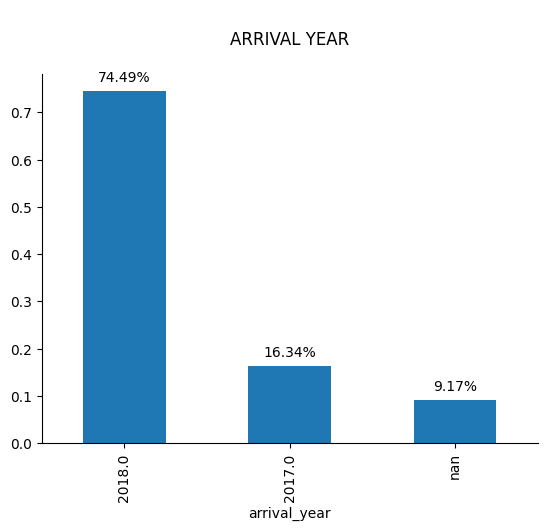

--------------------------------------------------
ARRIVAL_MONTH
--------------------------------------------------

2.78% is missing


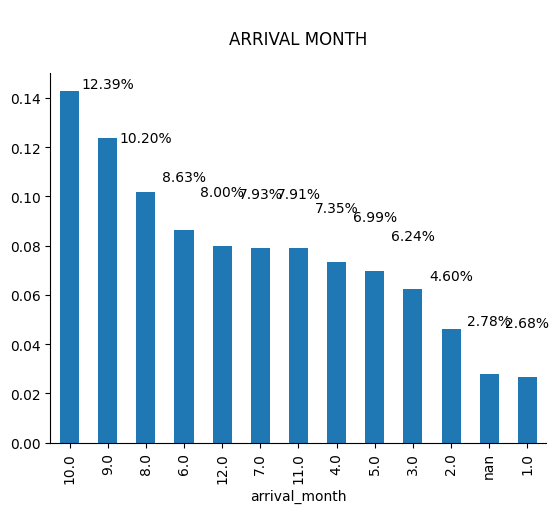

--------------------------------------------------
ARRIVAL_DATE
--------------------------------------------------

16.72% above 0
83.28% is missing


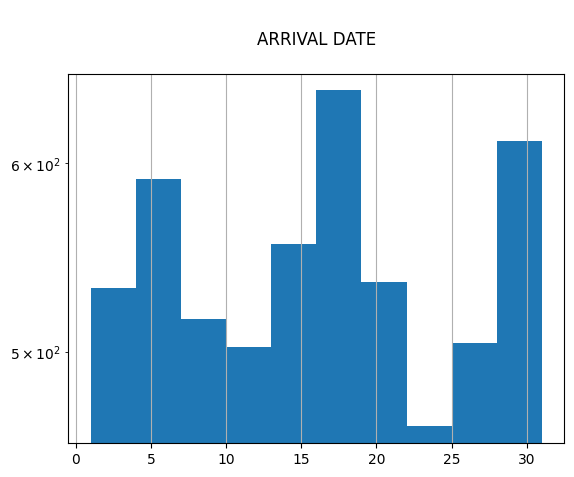

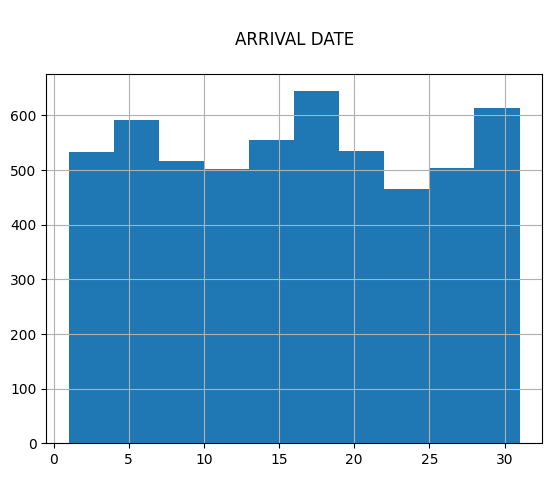

--------------------------------------------------
MARKET_SEGMENT_TYPE
--------------------------------------------------

43.25% is missing


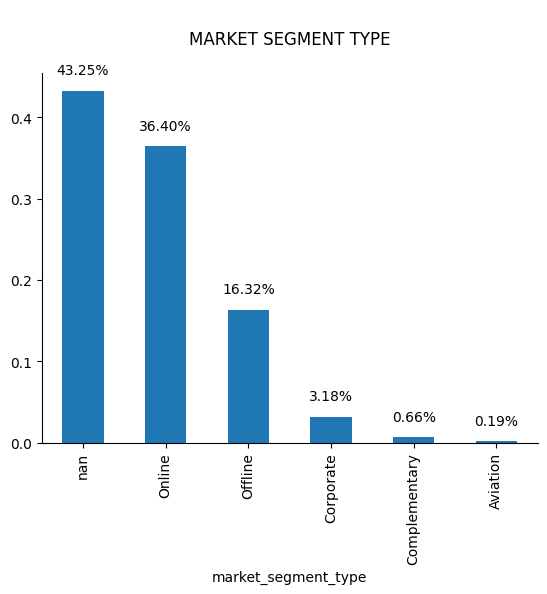

--------------------------------------------------
REPEATED_GUEST
--------------------------------------------------

76.51% is missing


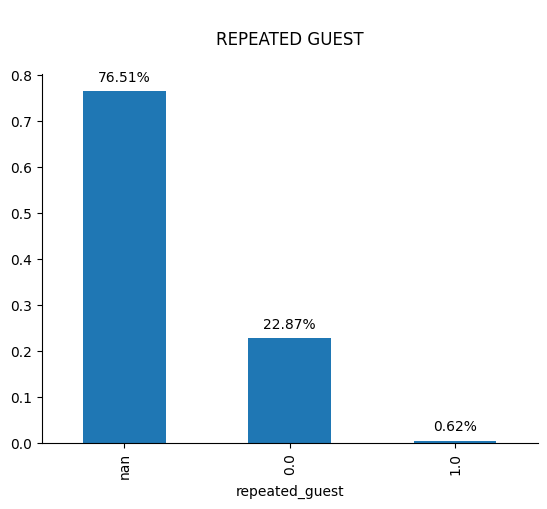

--------------------------------------------------
NO_OF_PREVIOUS_CANCELLATIONS
--------------------------------------------------

0.21% is missing


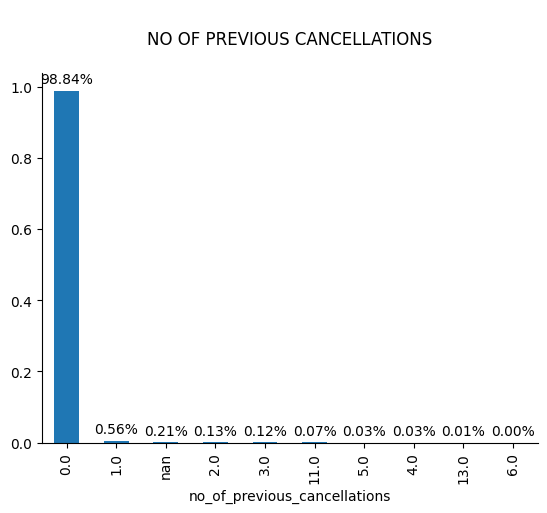

--------------------------------------------------
NO_OF_PREVIOUS_BOOKINGS_NOT_CANCELED
--------------------------------------------------

1.29% above 0
44.79% is missing


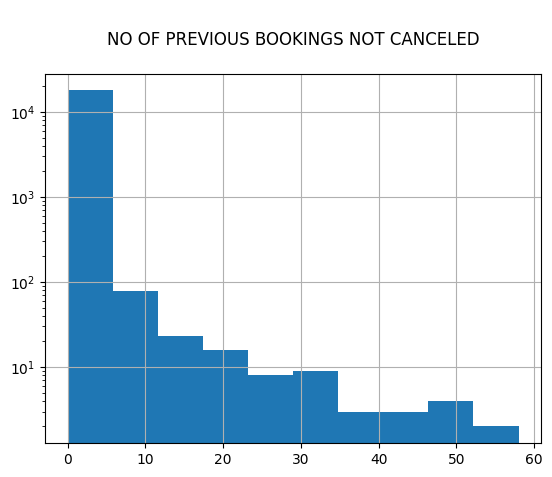

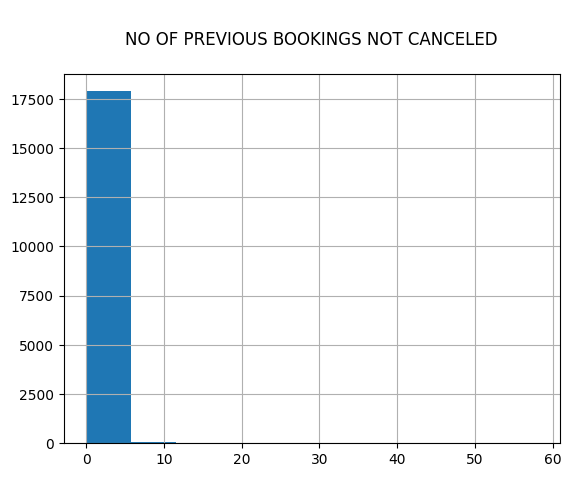

--------------------------------------------------
AVG_PRICE_PER_ROOM
--------------------------------------------------

27.33% above 0
72.25% is missing


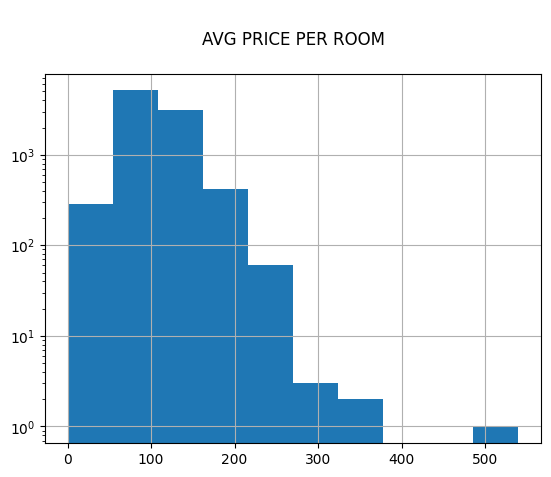

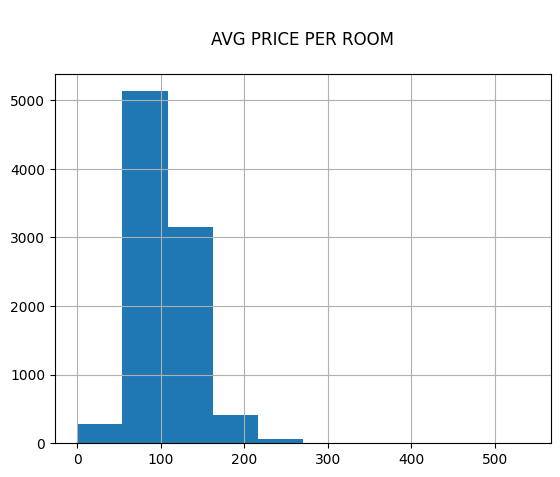

--------------------------------------------------
NO_OF_SPECIAL_REQUESTS
--------------------------------------------------

22.82% is missing


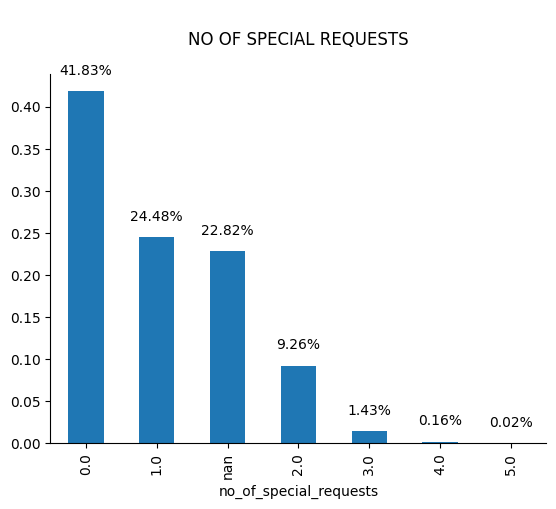

--------------------------------------------------
BOOKING_STATUS
--------------------------------------------------

1.08% is missing


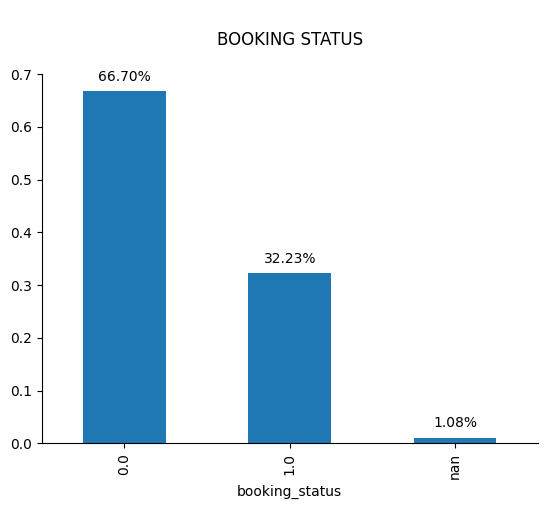

--------------------------------------------------
SAMPLE
--------------------------------------------------

0.00% is missing


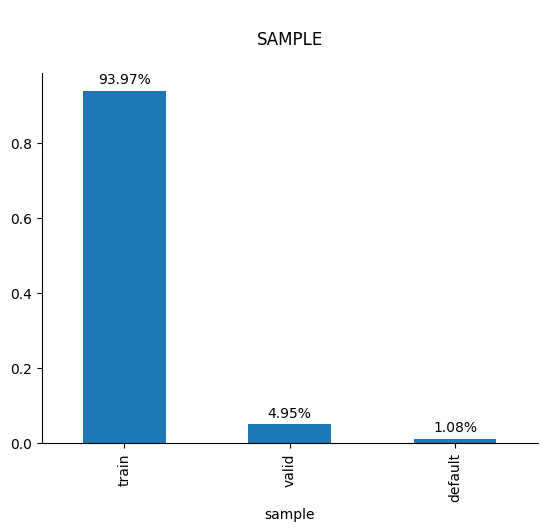

In [101]:
plot_columns(data.columns, data)


# Data preprocessing

Mentioned above, our dataset contains categorical variables with more than two levels. In this case we will need to provide numerical value for xgboost. For this particular reason we have chosen Category encoding described and implemented below.

## Encode Categorical Predictors
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot Booking_{category} + \alpha \cdot Booking}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $Booking_{category}$ average booking status in this category and $Booking$ is overall average booking status.

In [102]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_booking = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_booking = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_booking'] + alpha * total_booking) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [103]:
total_booking = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [104]:
#Our predictors
cols_pred

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

# XGBoost model
XGBoost model is provided in package `xgboost` and we followed reccomandation from https://xgboost.readthedocs.io/en/stable/. #??? Correct?

## Model Fitting

In this part, we will attempt to fit the model using #BLABALABL. We should warn that, in order to save time, we manually deleted predictors deemed weak (yes, it's barbaric, but effective nonetheless). So, if one wants to see the graphical reasoning, one should comment out the following two lines below and come back when ready.

In [105]:
#Removing insignificant predictors
cols_pred.remove('no_of_children')
cols_pred.remove('no_of_previous_cancellations')



In [106]:
xgb_model = xgb.XGBClassifier()

In [107]:
# finding optimal parameters using cross validation
#round1:
param_grid = {
    'max_depth': [6,7,8],
    'eta': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1]
}

In [52]:
#round2: (bez dětí)
param_grid = {
    'max_depth': [9,10,11],
    'eta': [0.1, 0.09, 0.08],
    'gamma': [1, 1.1, 1.2],
    'tree_method': ['exact','auto']
}

In [64]:
#round2: (bez dětí a cancellations)
param_grid = {
    'max_depth': [9,10,11],
    'eta': [0.12, 0.11, 0.1],
    'gamma': [1.1, 1.2, 1.3],
    'tree_method': ['exact','auto']
}

In [139]:
#round2: (bez dětí a cancellations a rep_guest)
param_grid = {
    'max_depth': [12,13,14],
    'eta': [0.12, 0.13, 0.14],
    'gamma': [2.9, 3, 3.1],
    'tree_method': ['exact','auto']
}

In [109]:
#from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = xgb_model,
                  param_grid = param_grid,
                  scoring = 'roc_auc',
                  cv=5,
                  verbose=4
                 )

In [110]:
#Algortithm that enables us to try different combinations of hyper parametets.
grid_search.fit(data[train_mask][cols_pred], data[train_mask][col_target]) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END .....eta=0.1, gamma=0, max_depth=6;, score=0.816 total time=   0.3s
[CV 2/5] END .....eta=0.1, gamma=0, max_depth=6;, score=0.811 total time=   0.2s
[CV 3/5] END .....eta=0.1, gamma=0, max_depth=6;, score=0.817 total time=   0.2s
[CV 4/5] END .....eta=0.1, gamma=0, max_depth=6;, score=0.812 total time=   0.3s
[CV 5/5] END .....eta=0.1, gamma=0, max_depth=6;, score=0.811 total time=   0.3s
[CV 1/5] END .....eta=0.1, gamma=0, max_depth=7;, score=0.818 total time=   0.3s
[CV 2/5] END .....eta=0.1, gamma=0, max_depth=7;, score=0.812 total time=   0.3s
[CV 3/5] END .....eta=0.1, gamma=0, max_depth=7;, score=0.819 total time=   0.4s
[CV 4/5] END .....eta=0.1, gamma=0, max_depth=7;, score=0.812 total time=   0.3s
[CV 5/5] END .....eta=0.1, gamma=0, max_depth=7;, score=0.814 total time=   0.3s
[CV 1/5] END .....eta=0.1, gamma=0, max_depth=8;, score=0.820 total time=   0.4s
[CV 2/5] END .....eta=0.1, gamma=0, max_depth=8

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'eta': [0.1, 0.05, 0.01], 'gamma': [0, 0.25, 1],
                         'max_depth': [6, 7, 8]},
             scoring='roc_auc', verbose=4)

In [111]:
#Moreover provides us with the final version
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_params


{'eta': 0.1, 'gamma': 0, 'max_depth': 8}

In [112]:
# set best parameters to be used in XGBoost
#Aktuálně nejlepší model na kaggle, učený bez dětí, prev_cancellations a repeated_guest, 0.9 train, 0.1 valid a žádný test
#'eta': 0.13, 'gamma': 3, 'max_depth': 13, 'tree_method': 'exact' určeno pomocí GridSearchCV
params = {    
    'max_depth': 13,
    'eta': 0.13,
    'gamma': 3,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        #(xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)

[0]	train-auc:0.82665	valid-auc:0.78884
[1]	train-auc:0.83128	valid-auc:0.79593
[2]	train-auc:0.83423	valid-auc:0.79725
[3]	train-auc:0.83751	valid-auc:0.80149
[4]	train-auc:0.84161	valid-auc:0.80577
[5]	train-auc:0.84507	valid-auc:0.80611
[6]	train-auc:0.84791	valid-auc:0.80813
[7]	train-auc:0.84921	valid-auc:0.80802
[8]	train-auc:0.85057	valid-auc:0.80906
[9]	train-auc:0.85148	valid-auc:0.80953
[10]	train-auc:0.85226	valid-auc:0.81009
[11]	train-auc:0.85357	valid-auc:0.81136
[12]	train-auc:0.85739	valid-auc:0.81161
[13]	train-auc:0.86028	valid-auc:0.81224
[14]	train-auc:0.86255	valid-auc:0.81375
[15]	train-auc:0.86455	valid-auc:0.81488
[16]	train-auc:0.86531	valid-auc:0.81591
[17]	train-auc:0.86587	valid-auc:0.81678
[18]	train-auc:0.86599	valid-auc:0.81757
[19]	train-auc:0.86700	valid-auc:0.81805
[20]	train-auc:0.86715	valid-auc:0.81833
[21]	train-auc:0.86915	valid-auc:0.81867
[22]	train-auc:0.86967	valid-auc:0.81949
[23]	train-auc:0.86990	valid-auc:0.81987
[24]	train-auc:0.87144	val

In [107]:
# set best parameters to be used in XGBoost
#Aktuálně nejlepší model na kaggle, učený bez dětí a prev_cancellations, 0.9 train, 0.1 valid a žádný test
#'eta': 0.1, 'gamma': 1, 'max_depth': 12, 'tree_method': 'exact' určeno pomocí GridSearchCV
#při splitu dat 95/5 'eta': 0.11, 'gamma': 1.2, 'max_depth': 10, 'tree_method': 'exact'
params = {    
    'max_depth': 10,
    'eta': 0.11,
    'gamma': 1.2,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        #(xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)

[0]	train-auc:0.80495	test-auc:0.76801	valid-auc:0.80085
[1]	train-auc:0.80723	test-auc:0.76887	valid-auc:0.80941
[2]	train-auc:0.80998	test-auc:0.76878	valid-auc:0.80882
[3]	train-auc:0.81306	test-auc:0.77236	valid-auc:0.81070
[4]	train-auc:0.81887	test-auc:0.77441	valid-auc:0.81436
[5]	train-auc:0.82111	test-auc:0.77616	valid-auc:0.81343
[6]	train-auc:0.82261	test-auc:0.77642	valid-auc:0.81332
[7]	train-auc:0.82367	test-auc:0.77713	valid-auc:0.81532
[8]	train-auc:0.82669	test-auc:0.77830	valid-auc:0.81610
[9]	train-auc:0.82721	test-auc:0.77952	valid-auc:0.81685
[10]	train-auc:0.82934	test-auc:0.77980	valid-auc:0.81840
[11]	train-auc:0.83038	test-auc:0.78181	valid-auc:0.82030
[12]	train-auc:0.83406	test-auc:0.78318	valid-auc:0.82357
[13]	train-auc:0.83647	test-auc:0.78591	valid-auc:0.82329
[14]	train-auc:0.83864	test-auc:0.78702	valid-auc:0.82390
[15]	train-auc:0.84063	test-auc:0.78872	valid-auc:0.82398
[16]	train-auc:0.84335	test-auc:0.78986	valid-auc:0.82469
[17]	train-auc:0.84541	t

In [192]:
# set best parameters to be used in XGBoost
#cols_pred.remove('no_of_children')
params = {    
    'max_depth': 10,
    'eta': 0.09,
    'gamma': 1.1,
    'tree_method': 'exact',
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        #(xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)


[0]	train-auc:0.80479	valid-auc:0.78465
[1]	train-auc:0.80801	valid-auc:0.78784
[2]	train-auc:0.80973	valid-auc:0.79052
[3]	train-auc:0.81114	valid-auc:0.79167
[4]	train-auc:0.81336	valid-auc:0.79251
[5]	train-auc:0.81628	valid-auc:0.79469
[6]	train-auc:0.81802	valid-auc:0.79545
[7]	train-auc:0.82060	valid-auc:0.79576
[8]	train-auc:0.82144	valid-auc:0.79584
[9]	train-auc:0.82284	valid-auc:0.79598
[10]	train-auc:0.82587	valid-auc:0.79801
[11]	train-auc:0.82649	valid-auc:0.79899
[12]	train-auc:0.82889	valid-auc:0.80018
[13]	train-auc:0.83006	valid-auc:0.80093
[14]	train-auc:0.83285	valid-auc:0.80169
[15]	train-auc:0.83585	valid-auc:0.80253
[16]	train-auc:0.83808	valid-auc:0.80280
[17]	train-auc:0.83982	valid-auc:0.80315
[18]	train-auc:0.84129	valid-auc:0.80336
[19]	train-auc:0.84319	valid-auc:0.80440
[20]	train-auc:0.84409	valid-auc:0.80479
[21]	train-auc:0.84490	valid-auc:0.80489
[22]	train-auc:0.84618	valid-auc:0.80519
[23]	train-auc:0.84669	valid-auc:0.80555
[24]	train-auc:0.84752	val

In [402]:
# set best parameters to be used in XGBoost
#cols_pred.remove('no_of_children')
params = {    
    'max_depth': 7,
    'eta': 0.05,    
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
    'booster': 'gbtree',
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 25
)


[0]	train-auc:0.77164	valid-auc:0.76616
[1]	train-auc:0.77274	valid-auc:0.76787
[2]	train-auc:0.77955	valid-auc:0.77238
[3]	train-auc:0.78550	valid-auc:0.77509
[4]	train-auc:0.78648	valid-auc:0.77566
[5]	train-auc:0.78667	valid-auc:0.77643
[6]	train-auc:0.78813	valid-auc:0.77627
[7]	train-auc:0.78987	valid-auc:0.77677
[8]	train-auc:0.79033	valid-auc:0.77667
[9]	train-auc:0.79073	valid-auc:0.77714
[10]	train-auc:0.79234	valid-auc:0.77793
[11]	train-auc:0.79305	valid-auc:0.77887
[12]	train-auc:0.79366	valid-auc:0.78080
[13]	train-auc:0.79411	valid-auc:0.78071
[14]	train-auc:0.79713	valid-auc:0.78349
[15]	train-auc:0.79750	valid-auc:0.78455
[16]	train-auc:0.79844	valid-auc:0.78507
[17]	train-auc:0.79954	valid-auc:0.78585
[18]	train-auc:0.80145	valid-auc:0.78703
[19]	train-auc:0.80190	valid-auc:0.78777
[20]	train-auc:0.80269	valid-auc:0.78881
[21]	train-auc:0.80379	valid-auc:0.78936
[22]	train-auc:0.80524	valid-auc:0.79001
[23]	train-auc:0.80628	valid-auc:0.79043
[24]	train-auc:0.80768	val

In [70]:
# set best parameters to be used in XGBoost
#cols_pred.remove('no_of_children')
params = {    
    'eta': 0.1,
    'max_depth': 6,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:type_of_meal_plan: object, room_type_reserved: object, market_segment_type: object

## Model evaluation

In the first figure we visualized AUC curve as is #??? we see stopping time and BALBABALA. In second graph we may see plotted importance for predictors. This tool also helped us in deciding, which predictor to remove from the model. 

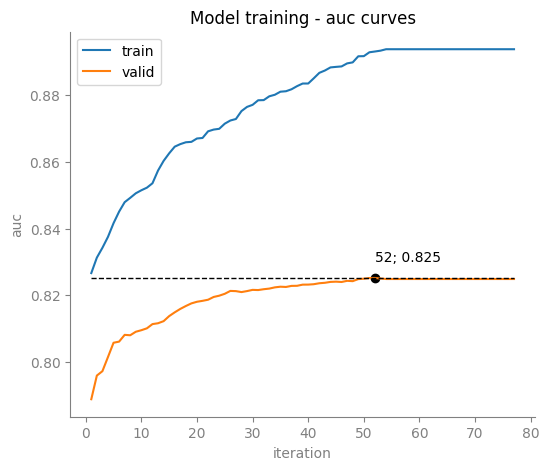

In [113]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1
#best_iteration = 51
ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

In [114]:
#evals_result['test']['auc'][booster.best_iteration+1] #???

KeyError: 'test'

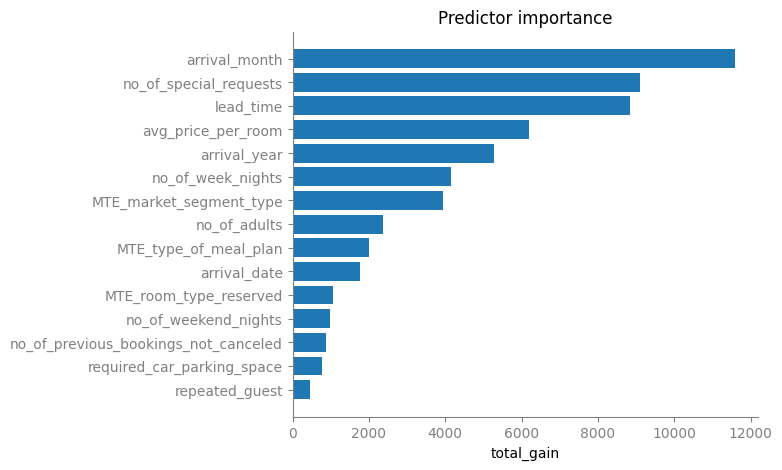

,predictor,strength
0,arrival_month,11601.598633
1,no_of_special_requests,9094.666992
2,lead_time,8842.960938
3,avg_price_per_room,6196.975098
4,arrival_year,5273.441895
5,no_of_week_nights,4159.524414
6,MTE_market_segment_type,3943.194580
7,no_of_adults,2365.386719
8,MTE_type_of_meal_plan,2013.556396
9,arrival_date,1777.440063


In [115]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 15 # Needs to be adjusted
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:15]) # Needs to be adjusted
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:15]) # Needs to be adjusted
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()
predictor_strength

# Prediction

In order to apply our model for the second dataset we need to, once again, make some adjustments to data. Firstly we need to encode the categorical predictors in same manner as in training dataset.

In [176]:
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(test_data[test_data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_booking

        test_data['MTE_' + pred] = test_data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/3 [00:00<?, ?it/s]

In [74]:
#Colums used for prediction
cols_pred

['no_of_adults',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'required_car_parking_space',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'repeated_guest',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_market_segment_type']

In [72]:
#Prediction
dtest = xgb.DMatrix(test_data[cols_pred])
ypred = booster.predict(dtest, iteration_range=(0, booster.best_iteration + 1))

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:type_of_meal_plan: object, room_type_reserved: object, market_segment_type: object

## Export

In [178]:
#Exporting data in desired structure
test_data_reset = test_data.reset_index()

# Create a DataFrame with booking IDs and predicted probabilities
predictions_df = pd.DataFrame({
    'Booking_ID': test_data_reset['Booking_ID'],  # Assuming 'Booking_ID' is the name of the index
    'booking_status': ypred
})
predictions_df

,booking_id,predicted_probability
0,INN04969,0.003053
1,INN34541,0.118725
2,INN36109,0.175726
3,INN01554,0.820128
4,INN24975,0.205063
...,...,...
3588,INN29523,0.020702
3589,INN25061,0.442948
3590,INN08475,0.938490
3591,INN13558,0.010190


In [26]:
#In order for the exporting method to work, we isntalled openpyxl library
#pip install openpyxl

In [26]:
from openpyxl import Workbook

In [179]:
# Export DataFrame to Excel
predictions_df.to_excel("predictions12.xlsx", index=False)

print("DataFrame successfully exported to Excel.")

DataFrame successfully exported to Excel.


## Final model
Before fitting final model, selection of optimal predictors might be considered. A model with similar performance can be fitted using *n* strongest predictors or using all available predictors. Sometime implementation of the predictors into the production might take some time and therefore you prefer to have "reasonable" number of predictors in your model. On the contrary, having larger number of predictors might bring better robustness - if one of the predictors would broke, the impact for the model would be lower.

For selection of optimal predictors, similar approach as forward (or backward) process can be used.

### Cross validation score

In [117]:
params={
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

skf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 12)

X = data[cols_pred].values
y = data[col_target].values
data['cv_score'] = -1.0
cv_res = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    evals_result = {}
    booster = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(X_train, y_train),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(X_train, y_train), 'train'),
            (xgb.DMatrix(X_test, y_test), 'test'),
        ),
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = True
    )
    
    gini_train = 2 * roc_auc_score(y_train, booster.predict(xgb.DMatrix(X_train))) - 1
    gini_test  = 2 * roc_auc_score(y_test,  booster.predict(xgb.DMatrix(X_test)))  - 1
    best_iteration = booster.best_iteration
    
    cv_res += [(gini_train, gini_test, best_iteration)]
    
    data.iloc[test_index, list(data.columns).index('cv_score')] = list(booster.predict(xgb.DMatrix(X_test), iteration_range=(0, booster.best_iteration)))

ValueError: Input y contains NaN.

In [116]:
# Performance during cross validation
cv_res

NameError: name 'cv_res' is not defined

In [32]:
gini_cv = 2 * roc_auc_score(data[col_target], data['cv_score']) - 1
print(f'Cross validation score performance: {gini_cv:.4f}')

D:\Projects\ds2-hw\.venv\lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

In [33]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = 130,
    evals_result = evals_result
)

XGBoostError: [17:47:32] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\data\data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.

In [34]:
gini_train = 2 * roc_auc_score(data[col_target], booster.predict(xgb.DMatrix(data[cols_pred]))) - 1
print(gini_train)

D:\Projects\ds2-hw\.venv\lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_true contains NaN.

### Final model using splitted data

In [79]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': ['auc'],
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12,
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 20,
    verbose_eval = True
)

[0]	train-auc:0.68233	test-auc:0.67915	valid-auc:0.69247
[1]	train-auc:0.72408	test-auc:0.72158	valid-auc:0.73227
[2]	train-auc:0.73076	test-auc:0.72866	valid-auc:0.73505
[3]	train-auc:0.73474	test-auc:0.73053	valid-auc:0.73678
[4]	train-auc:0.74021	test-auc:0.73583	valid-auc:0.74342
[5]	train-auc:0.75160	test-auc:0.74740	valid-auc:0.75699
[6]	train-auc:0.75660	test-auc:0.75250	valid-auc:0.76332
[7]	train-auc:0.76637	test-auc:0.75990	valid-auc:0.77357
[8]	train-auc:0.76609	test-auc:0.75947	valid-auc:0.77272
[9]	train-auc:0.76241	test-auc:0.75509	valid-auc:0.76859
[10]	train-auc:0.76128	test-auc:0.75614	valid-auc:0.77026
[11]	train-auc:0.76630	test-auc:0.76146	valid-auc:0.77418
[12]	train-auc:0.76904	test-auc:0.76388	valid-auc:0.77692
[13]	train-auc:0.76957	test-auc:0.76442	valid-auc:0.77735
[14]	train-auc:0.76888	test-auc:0.76379	valid-auc:0.77695
[15]	train-auc:0.77144	test-auc:0.76561	valid-auc:0.77889
[16]	train-auc:0.77527	test-auc:0.76903	valid-auc:0.78109
[17]	train-auc:0.77523	t

In [39]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'monotone_constraints': constr,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-auc:0.68233	test-auc:0.67915	valid-auc:0.69247
[1]	train-auc:0.72408	test-auc:0.72158	valid-auc:0.73227
[2]	train-auc:0.73076	test-auc:0.72866	valid-auc:0.73505
[3]	train-auc:0.73474	test-auc:0.73053	valid-auc:0.73678
[4]	train-auc:0.74021	test-auc:0.73583	valid-auc:0.74342
[5]	train-auc:0.75160	test-auc:0.74740	valid-auc:0.75699
[6]	train-auc:0.75660	test-auc:0.75250	valid-auc:0.76332
[7]	train-auc:0.76637	test-auc:0.75990	valid-auc:0.77357
[8]	train-auc:0.76609	test-auc:0.75947	valid-auc:0.77272
[9]	train-auc:0.76241	test-auc:0.75509	valid-auc:0.76859
[10]	train-auc:0.76128	test-auc:0.75614	valid-auc:0.77026
[11]	train-auc:0.76630	test-auc:0.76146	valid-auc:0.77418
[12]	train-auc:0.76904	test-auc:0.76388	valid-auc:0.77692
[13]	train-auc:0.76957	test-auc:0.76442	valid-auc:0.77735
[14]	train-auc:0.76888	test-auc:0.76379	valid-auc:0.77695
[15]	train-auc:0.77144	test-auc:0.76561	valid-auc:0.77889
[16]	train-auc:0.77527	test-auc:0.76903	valid-auc:0.78109
[17]	train-auc:0.77523	t

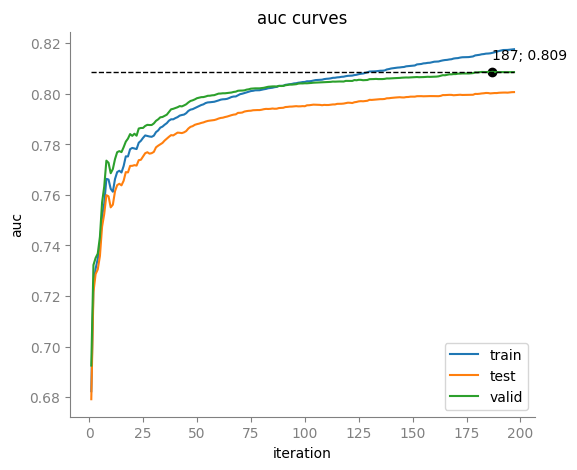

In [40]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# Model validation

In [118]:
data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,booster.best_iteration))
data['predicted_score'] = np.log(data['predicted_pd'] / (1 - data['predicted_pd']))

## Plot individual trees

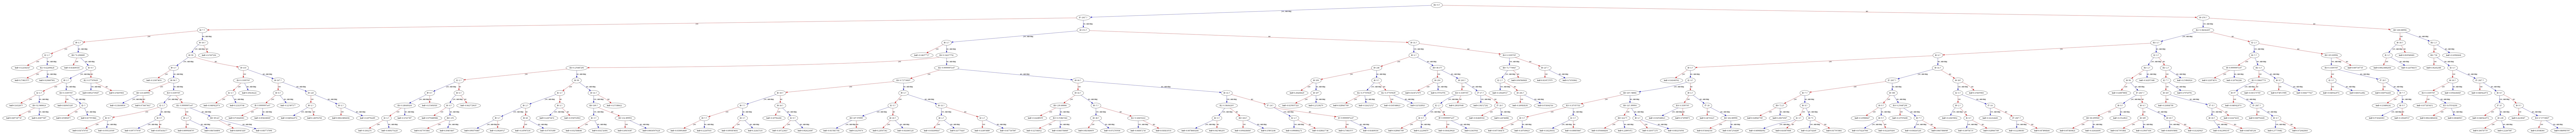

In [96]:
# TODO: To make the following line work you need to install graphviz (if you have not done so in one of the previous classes)
# 1) follow the instructions https://graphviz.gitlab.io/download/?fbclid=IwAR1V-lrRhho5rSfBVYXYISsighqRwOCOgMHLmL_DclkQrPtMXQaKj3mFcqs
# 2) this notebook has been tested with version 8.0.3
# 3) make sure you add it to the PATH variable (you are specifically asked during the installation) at least for local user

from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 160,100

plot_tree(booster_sklearn, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

## Score distribution

In [119]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin', observed=False).agg(
        bad_cnt = (col_target, 'sum'),
        tot_cnt = (col_target, len),
        def_rt = (col_target, 'mean'),
        avg_score = (col_score, 'mean')
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

In [120]:
plot_score_calibration(data[valid_mask | test_mask], 'predicted_score', col_target)

NameError: name 'test_mask' is not defined

## Permutation importance
- Let's have dataset $D$ and model with score (AUC for instance) $s$
- For each feature $j$ calculate permutation importance as follows:
    - for $k$ in $1,\ldots,K$:
        - shuffle column $j$ in dataset $D$ -> $\hat{D}_{k,j}$
        - compute the score $s_{k,j}$ using $\hat{D}_{k,j}$
    - importance $i_j$ for feature $f_j$ is defined as:
$$i_j = s - \frac{1}{K}\sum_{k=1}^K s_{k,j}$$

In [35]:
from sklearn.inspection import permutation_importance

In [36]:
# for sklearn, there is a function
r = permutation_importance(booster_sklearn, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=6)

In [37]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cols_pred[i]:<8}    "
              f"{r.importances_mean[i]:.4f}"
              f" +/- {r.importances_std[i]:.4f}")

AMT_CREDIT    0.0005 +/- 0.0002
LAST_TRANSACTION_TIME_MONTHS    0.0002 +/- 0.0001
YEARS_BEGINEXPLUATATION_MEDI    0.0001 +/- 0.0000


In [38]:
def permutation_importance(dt, predictor, target, model, n_iters = 10):
    predictors = list(dt.columns)
    predictors.remove(target)
    
    prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
    s = roc_auc_score(dt[target], prediction)
    
    sk = []
    for i in range(n_iters):
        x = dt[predictor].to_list()
        np.random.shuffle(x)
        dt[predictor] = x
        prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
        sk.append(roc_auc_score(dt[target], prediction))
    
    sk_mean = np.mean(sk)
    sk_perc05 = np.percentile(sk, q=5)
    sk_perc95 = np.percentile(sk, q=95)
    
    return s - sk_mean, s - sk_perc05, s - sk_perc95    

In [39]:
res = []
for pred in tqdm(cols_pred[0:10]):
    pi, iqr95, iqr05 = permutation_importance(
        dt=data[test_mask][cols_pred + [col_target]], 
        predictor=pred,
        target=col_target,
        model=booster,
        n_iters=10
    )
    res.append((pred, pi, iqr05, iqr95))
res = pd.DataFrame(res, columns = ['predictor', 'permutation_importance', 'iqr05', 'iqr95'])
res

  0%|          | 0/10 [00:00<?, ?it/s]

,predictor,permutation_importance,iqr05,iqr95
0,CNT_CHILDREN,0.000055,-0.000031,0.000175
1,AMT_INCOME_TOTAL,-0.000091,-0.000190,0.000040
2,AMT_CREDIT,0.005137,0.003112,0.007115
3,AMT_ANNUITY,0.003547,0.002582,0.005227
4,AMT_GOODS_PRICE,0.008705,0.006394,0.011931
5,REGION_POPULATION_RELATIVE,0.000018,-0.000201,0.000282
6,DAYS_BIRTH,0.002190,0.001383,0.003270
7,DAYS_EMPLOYED,0.002630,0.001919,0.003418
8,DAYS_REGISTRATION,0.000174,-0.000522,0.000813
9,DAYS_ID_PUBLISH,0.001644,0.000670,0.002513


## Marginal contribution

In [77]:
def fit_model(predictors):
    params={
        'eta': 0.2,
        'max_depth': 3,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 20
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction = booster.predict(xgb.DMatrix(data[test_mask][cols_pred]), iteration_range=(0,booster.best_iteration))
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred[0:5]):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))

NameError: name 'booster' is not defined

In [41]:
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)

In [42]:
marginal_contribution

[('AMT_ANNUITY', 0.003294343459197435),
 ('CNT_CHILDREN', 0.004005871015915763),
 ('AMT_INCOME_TOTAL', 0.004469701186495367),
 ('AMT_CREDIT', 0.0046338794839145825),
 ('AMT_GOODS_PRICE', 0.006407799507157974)]

NameError: name 'marginal_contribution' is not defined

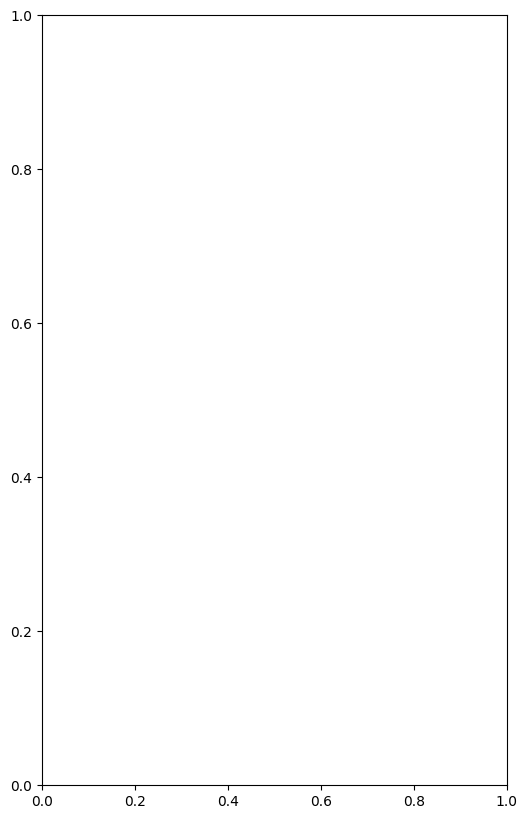

In [76]:
# feature_perm_importance = sorted(zip(cols_pred, pi['importances_mean']), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()